In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from typing import Tuple, Any, Dict, List
import json
import pandas as pd

In [3]:
from google.colab import drive, files
drive.mount('/content/drive')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Mounted at /content/drive
Num GPUs Available:  0


In [62]:
SEED: int = 123
INPUT_SHAPE: Tuple[int] = (64, 64, 1)
BATCH_SIZE: int = 32
IMAGES_PATH: str = "/content/drive/MyDrive/STUDIA/WDSN/Project/images/processed"
LABELS_PATH: str = "/content/drive/MyDrive/STUDIA/WDSN/Project/images/labels/labels.json"
MODELS_DIR: str = '/content/drive/MyDrive/STUDIA/WDSN/Project/models'

In [5]:
dataset: pd.DataFrame = pd.read_json(LABELS_PATH).T
dataset["filename"] = dataset.index

In [24]:
def compare_history(
    histories: List[Dict[str, Any]], 
    labels: List[str], 
    epochs: List[int], 
    metric: str = 'MAE'
    ) -> None:
    plt.figure()
    for history, label, epoch in zip(histories, labels, epochs):
        plt.plot(range(epoch), history.history['mean_absolute_error'], label=label+" train")
        plt.plot(range(epoch), history.history['val_mean_absolute_error'], label=label+" validation")
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.grid()
    plt.legend()
    plt.show()

In [70]:
better_train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      validation_split=0.2,
      rescale=1./255.,
      horizontal_flip=True,
      vertical_flip=True,

  ).flow_from_dataframe(
      dataset,
      directory=IMAGES_PATH,
      x_col='filename',
      y_col='mean',
      weight_col="weight",
      color_mode = "grayscale",
      batch_size=BATCH_SIZE,
      target_size=INPUT_SHAPE[:2],
      subset="training",
      class_mode="raw",
      shuffle=True,
      seed=SEED,
  )


better_valid_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      validation_split=0.2,
      rescale=1./255.,
      horizontal_flip=True,
      vertical_flip=True,
  ).flow_from_dataframe(
      dataset,
      directory=IMAGES_PATH,
      x_col='filename',
      y_col='mean',
      weight_col="weight",
      color_mode = "grayscale",
      batch_size=BATCH_SIZE,
      target_size=INPUT_SHAPE[:2],
      subset="validation",
      class_mode="raw",
      shuffle=True,
      seed=SEED,
  )


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:989: UserWarning: Found 7472 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


Found 1620 validated image filenames.
Found 405 validated image filenames.


# Base Model


In [15]:
model: keras.models = keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=INPUT_SHAPE),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear'),
])

model.compile(
    optimizer='adam',
    loss = tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanAbsoluteError()]
)

In [16]:
history = model.fit(
    better_train_generator, 
    epochs=15, 
    batch_size=BATCH_SIZE,
    validation_data=better_valid_generator
    )

Epoch 1/15
51/51 [==============================] - 356s 7s/step - loss: 12.7753 - mean_squared_error: 1.9019 - mean_absolute_error: 1.0693 - val_loss: 5.9602 - val_mean_squared_error: 0.6374 - val_mean_absolute_error: 0.6434
Epoch 2/15
51/51 [==============================] - 9s 180ms/step - loss: 4.8109 - mean_squared_error: 0.6876 - mean_absolute_error: 0.6404 - val_loss: 2.8799 - val_mean_squared_error: 0.4708 - val_mean_absolute_error: 0.5341
Epoch 3/15
51/51 [==============================] - 9s 181ms/step - loss: 4.3308 - mean_squared_error: 0.5734 - mean_absolute_error: 0.5900 - val_loss: 2.5579 - val_mean_squared_error: 0.3762 - val_mean_absolute_error: 0.4795
Epoch 4/15
51/51 [==============================] - 9s 181ms/step - loss: 3.9453 - mean_squared_error: 0.5222 - mean_absolute_error: 0.5578 - val_loss: 2.2595 - val_mean_squared_error: 0.3909 - val_mean_absolute_error: 0.4936
Epoch 5/15
51/51 [==============================] - 9s 183ms/step - loss: 3.8220 - mean_squared_

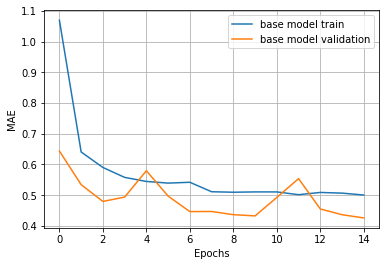

In [25]:
compare_history([history], ["base model"], [15])

In [28]:
model.save(os.path.join(MODELS_DIR, "raw_model.h5"))

# WIDE CONV FILTERS

In [32]:
model_wider: keras.models = keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=INPUT_SHAPE),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(7, 7), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear'),
])

model_wider.compile(
    optimizer='adam',
    loss = tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanAbsoluteError()]
)

In [33]:
history_wider = model_wider.fit(
    better_train_generator, 
    epochs=15, 
    batch_size=BATCH_SIZE,
    validation_data=better_valid_generator
    )

Epoch 1/15
51/51 [==============================] - 13s 232ms/step - loss: 9.8247 - mean_squared_error: 1.2904 - mean_absolute_error: 0.8771 - val_loss: 8.2338 - val_mean_squared_error: 0.7901 - val_mean_absolute_error: 0.7232
Epoch 2/15
51/51 [==============================] - 12s 226ms/step - loss: 5.3838 - mean_squared_error: 0.7170 - mean_absolute_error: 0.6680 - val_loss: 3.0505 - val_mean_squared_error: 0.5709 - val_mean_absolute_error: 0.6011
Epoch 3/15
51/51 [==============================] - 13s 263ms/step - loss: 4.3328 - mean_squared_error: 0.5824 - mean_absolute_error: 0.5926 - val_loss: 4.1916 - val_mean_squared_error: 0.4373 - val_mean_absolute_error: 0.5290
Epoch 4/15
51/51 [==============================] - 12s 225ms/step - loss: 4.7555 - mean_squared_error: 0.6093 - mean_absolute_error: 0.6113 - val_loss: 4.1368 - val_mean_squared_error: 0.8189 - val_mean_absolute_error: 0.7623
Epoch 5/15
51/51 [==============================] - 11s 224ms/step - loss: 4.3582 - mean_squ

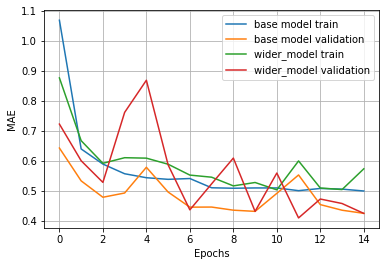

In [34]:
compare_history([history, history_wider], ["base model", "wider_model"], [15, 15])

# Intensive Dropout

In [46]:
model_elu: keras.models = keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=INPUT_SHAPE),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='elu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='elu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='elu'),
    tf.keras.layers.Dense(64, activation='elu'),
    tf.keras.layers.Dense(1, activation='linear'),
])

model_elu.compile(
    optimizer='adam',
    loss = tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanAbsoluteError()]
)

In [47]:
history_elu = model_elu.fit(
    better_train_generator, 
    epochs=15, 
    batch_size=BATCH_SIZE,
    validation_data=better_valid_generator
    )

Epoch 1/15
51/51 [==============================] - 12s 222ms/step - loss: 7.9930 - mean_squared_error: 1.1357 - mean_absolute_error: 0.8004 - val_loss: 3.5460 - val_mean_squared_error: 0.4056 - val_mean_absolute_error: 0.5081
Epoch 2/15
51/51 [==============================] - 10s 191ms/step - loss: 3.8717 - mean_squared_error: 0.5509 - mean_absolute_error: 0.5711 - val_loss: 2.8010 - val_mean_squared_error: 0.3628 - val_mean_absolute_error: 0.4717
Epoch 3/15
51/51 [==============================] - 12s 230ms/step - loss: 3.6874 - mean_squared_error: 0.4984 - mean_absolute_error: 0.5447 - val_loss: 3.2460 - val_mean_squared_error: 0.3434 - val_mean_absolute_error: 0.4712
Epoch 4/15
51/51 [==============================] - 10s 191ms/step - loss: 3.7225 - mean_squared_error: 0.4961 - mean_absolute_error: 0.5455 - val_loss: 3.8345 - val_mean_squared_error: 0.3627 - val_mean_absolute_error: 0.4912
Epoch 5/15
51/51 [==============================] - 10s 190ms/step - loss: 3.7002 - mean_squ

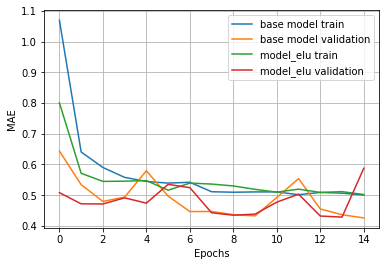

In [48]:
compare_history([history, history_elu], ["base model", "model_elu"], [15, 15])

In [49]:
model_elu.save(os.path.join(MODELS_DIR, "elu_model.h5"))

In [53]:
model_deeper: keras.models = keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=INPUT_SHAPE),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(.4),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(.4),
    tf.keras.layers.Dense(1, activation='linear'),
])

model_deeper.compile(
    optimizer='adam',
    loss = tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanAbsoluteError()]
)

In [54]:
history_deeper = model_deeper.fit(
    better_train_generator, 
    epochs=30, 
    batch_size=BATCH_SIZE,
    validation_data=better_valid_generator
    )

Epoch 1/30
51/51 [==============================] - 18s 338ms/step - loss: 18.4881 - mean_squared_error: 2.9460 - mean_absolute_error: 1.4431 - val_loss: 9.0353 - val_mean_squared_error: 1.7459 - val_mean_absolute_error: 1.1923
Epoch 2/30
51/51 [==============================] - 17s 328ms/step - loss: 10.4345 - mean_squared_error: 1.4612 - mean_absolute_error: 0.9906 - val_loss: 4.2052 - val_mean_squared_error: 0.8692 - val_mean_absolute_error: 0.7717
Epoch 3/30
51/51 [==============================] - 17s 325ms/step - loss: 9.5483 - mean_squared_error: 1.2645 - mean_absolute_error: 0.9059 - val_loss: 3.6252 - val_mean_squared_error: 0.7398 - val_mean_absolute_error: 0.7038
Epoch 4/30
51/51 [==============================] - 17s 323ms/step - loss: 8.2276 - mean_squared_error: 1.1551 - mean_absolute_error: 0.8690 - val_loss: 2.4970 - val_mean_squared_error: 0.3934 - val_mean_absolute_error: 0.4920
Epoch 5/30
51/51 [==============================] - 17s 325ms/step - loss: 7.2534 - mean_s

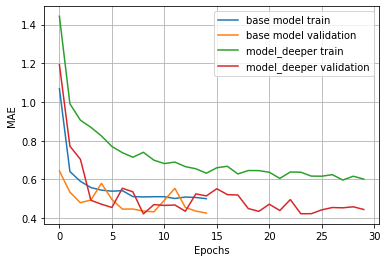

In [55]:
compare_history([history, history_deeper], ["base model", "model_deeper"], [15, 30])

# Very Wide Model

In [56]:
vw_model: keras.models = keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=INPUT_SHAPE),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(11, 11), activation='relu'),
    tf.keras.layers.MaxPool2D((5,5)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear'),
])

vw_model.compile(
    optimizer='adam',
    loss = tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanAbsoluteError()]
)

In [57]:
history_vw = vw_model.fit(
    better_train_generator, 
    epochs=15, 
    batch_size=BATCH_SIZE,
    validation_data=better_valid_generator
    )

Epoch 1/15
51/51 [==============================] - 23s 443ms/step - loss: 7.9334 - mean_squared_error: 1.1698 - mean_absolute_error: 0.8340 - val_loss: 3.9297 - val_mean_squared_error: 0.7933 - val_mean_absolute_error: 0.7275
Epoch 2/15
51/51 [==============================] - 24s 469ms/step - loss: 4.7966 - mean_squared_error: 0.7590 - mean_absolute_error: 0.6781 - val_loss: 4.9765 - val_mean_squared_error: 0.5518 - val_mean_absolute_error: 0.5877
Epoch 3/15
51/51 [==============================] - 22s 436ms/step - loss: 6.1935 - mean_squared_error: 0.8408 - mean_absolute_error: 0.7273 - val_loss: 3.3614 - val_mean_squared_error: 0.4625 - val_mean_absolute_error: 0.5277
Epoch 4/15
51/51 [==============================] - 22s 439ms/step - loss: 4.8374 - mean_squared_error: 0.6962 - mean_absolute_error: 0.6496 - val_loss: 2.9007 - val_mean_squared_error: 0.4872 - val_mean_absolute_error: 0.5428
Epoch 5/15
51/51 [==============================] - 24s 478ms/step - loss: 4.7209 - mean_squ

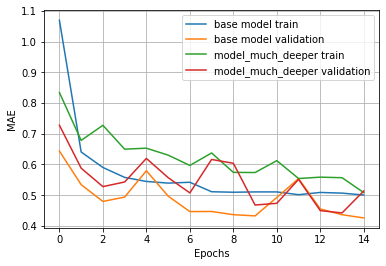

In [58]:
compare_history([history, history_vw], ["base model", "model_much_deeper"], [15, 15])

Dataset Augmented

In [68]:
model_ds_aug: tf.keras.models.Model = keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=INPUT_SHAPE),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='sigmoid'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='sigmoid'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(1, activation='linear'),
])

model_ds_aug.compile(
    optimizer='adam',
    loss = tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanAbsoluteError()]
)

In [71]:
history_da = model_ds_aug.fit(
    better_train_generator, 
    epochs=15, 
    batch_size=BATCH_SIZE,
    validation_data=better_valid_generator
    )

Epoch 1/15
51/51 [==============================] - 15s 298ms/step - loss: 46.9044 - mean_squared_error: 7.1245 - mean_absolute_error: 2.5996 - val_loss: 39.0028 - val_mean_squared_error: 6.2781 - val_mean_absolute_error: 2.4500
Epoch 2/15
51/51 [==============================] - 15s 294ms/step - loss: 34.6320 - mean_squared_error: 5.4041 - mean_absolute_error: 2.2353 - val_loss: 19.2437 - val_mean_squared_error: 3.2976 - val_mean_absolute_error: 1.7389
Epoch 3/15
51/51 [==============================] - 15s 296ms/step - loss: 10.7141 - mean_squared_error: 1.5432 - mean_absolute_error: 1.0157 - val_loss: 2.5580 - val_mean_squared_error: 0.4787 - val_mean_absolute_error: 0.5461
Epoch 4/15
51/51 [==============================] - 17s 341ms/step - loss: 6.4169 - mean_squared_error: 0.8616 - mean_absolute_error: 0.7329 - val_loss: 2.2257 - val_mean_squared_error: 0.3485 - val_mean_absolute_error: 0.4614
Epoch 5/15
51/51 [==============================] - 17s 335ms/step - loss: 5.2577 - mea

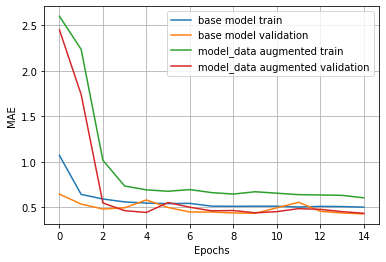

In [74]:
compare_history([history, history_da], ["base model", "model_data augmented"], [15, 15])

In [75]:
model_sig: tf.keras.models.Model = keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=INPUT_SHAPE),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='sigmoid'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='sigmoid'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(1, activation='linear'),
])

model_sig.compile(
    optimizer='adam',
    loss = tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanAbsoluteError()]
)

In [78]:
history_sig = model_sig.fit(
    better_train_generator, 
    epochs=15, 
    batch_size=BATCH_SIZE,
    validation_data=better_valid_generator
    )

Epoch 1/15
51/51 [==============================] - 18s 326ms/step - loss: 6.4856 - mean_squared_error: 0.9370 - mean_absolute_error: 0.7638 - val_loss: 2.1833 - val_mean_squared_error: 0.3266 - val_mean_absolute_error: 0.4467
Epoch 2/15
51/51 [==============================] - 16s 316ms/step - loss: 4.9845 - mean_squared_error: 0.6361 - mean_absolute_error: 0.6294 - val_loss: 2.1900 - val_mean_squared_error: 0.3404 - val_mean_absolute_error: 0.4529
Epoch 3/15
51/51 [==============================] - 16s 316ms/step - loss: 5.1868 - mean_squared_error: 0.6214 - mean_absolute_error: 0.6200 - val_loss: 2.2229 - val_mean_squared_error: 0.3017 - val_mean_absolute_error: 0.4322
Epoch 4/15
51/51 [==============================] - 16s 317ms/step - loss: 4.5966 - mean_squared_error: 0.6036 - mean_absolute_error: 0.6132 - val_loss: 2.1832 - val_mean_squared_error: 0.3242 - val_mean_absolute_error: 0.4451
Epoch 5/15
51/51 [==============================] - 17s 325ms/step - loss: 4.5512 - mean_squ

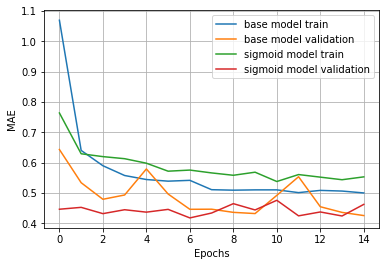

In [79]:
compare_history([history, history_sig], ["base model", "sigmoid model"], [15, 15])

In [80]:
model_sig_: tf.keras.models.Model = keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=INPUT_SHAPE),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='sigmoid'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation='sigmoid'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(7, 7), activation='sigmoid'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(16, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='linear'),
])

model_sig_.compile(
    optimizer='rmsprop',
    loss = tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanAbsoluteError()]
)

In [81]:
history_sig_ = model_sig_.fit(
    better_train_generator, 
    epochs=15, 
    batch_size=BATCH_SIZE,
    validation_data=better_valid_generator
    )

Epoch 1/15
51/51 [==============================] - 32s 604ms/step - loss: 9.7642 - mean_squared_error: 1.6087 - mean_absolute_error: 1.0789 - val_loss: 2.5547 - val_mean_squared_error: 0.4877 - val_mean_absolute_error: 0.5466
Epoch 2/15
51/51 [==============================] - 30s 589ms/step - loss: 3.5254 - mean_squared_error: 0.4425 - mean_absolute_error: 0.5139 - val_loss: 2.1951 - val_mean_squared_error: 0.3108 - val_mean_absolute_error: 0.4375
Epoch 3/15
51/51 [==============================] - 32s 636ms/step - loss: 3.3866 - mean_squared_error: 0.4004 - mean_absolute_error: 0.4905 - val_loss: 2.2527 - val_mean_squared_error: 0.2936 - val_mean_absolute_error: 0.4256
Epoch 4/15
51/51 [==============================] - 31s 612ms/step - loss: 3.3690 - mean_squared_error: 0.3970 - mean_absolute_error: 0.4888 - val_loss: 2.2585 - val_mean_squared_error: 0.2929 - val_mean_absolute_error: 0.4251
Epoch 5/15
51/51 [==============================] - 31s 598ms/step - loss: 3.3968 - mean_squ

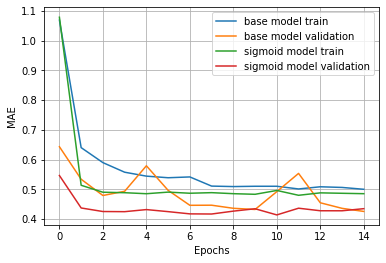

In [82]:
compare_history([history, history_sig_], ["base model", "sigmoid model"], [15, 15])

In [83]:
model_sig_.save(os.path.join(MODELS_DIR, "simoidal_model.h5"))

In [87]:
model_sig_convolved: tf.keras.models.Model = keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=INPUT_SHAPE),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='sigmoid'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation='sigmoid'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(7, 7), activation='sigmoid'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(9, 9), activation='sigmoid'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(16, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='linear'),
])

model_sig_convolved.compile(
    optimizer='rmsprop',
    loss = tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanAbsoluteError()])

In [88]:
history_sig_conv = model_sig_convolved.fit(
    better_train_generator, 
    epochs=15, 
    batch_size=BATCH_SIZE,
    validation_data=better_valid_generator
    )

Epoch 1/15
51/51 [==============================] - 111s 2s/step - loss: 33.0580 - mean_squared_error: 5.0244 - mean_absolute_error: 2.0906 - val_loss: 9.6834 - val_mean_squared_error: 1.7875 - val_mean_absolute_error: 1.2317
Epoch 2/15
51/51 [==============================] - 107s 2s/step - loss: 6.2314 - mean_squared_error: 0.9991 - mean_absolute_error: 0.8145 - val_loss: 2.2465 - val_mean_squared_error: 0.3751 - val_mean_absolute_error: 0.4764
Epoch 3/15
51/51 [==============================] - 108s 2s/step - loss: 3.4017 - mean_squared_error: 0.4242 - mean_absolute_error: 0.5058 - val_loss: 2.2426 - val_mean_squared_error: 0.2935 - val_mean_absolute_error: 0.4272
Epoch 4/15
51/51 [==============================] - 106s 2s/step - loss: 3.3847 - mean_squared_error: 0.3939 - mean_absolute_error: 0.4861 - val_loss: 2.2416 - val_mean_squared_error: 0.2928 - val_mean_absolute_error: 0.4256
Epoch 5/15
51/51 [==============================] - 108s 2s/step - loss: 3.3769 - mean_squared_erro

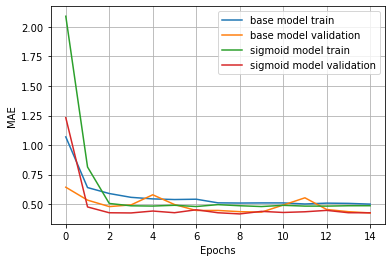

In [89]:
compare_history([history, history_sig_conv], ["base model", "sigmoid model"], [15, 15])

In [92]:
model_sig_convolved.save(os.path.join(MODELS_DIR, "simoidal_hard_model.h5"))

In [90]:
model_sig_MAE: tf.keras.models.Model = keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=INPUT_SHAPE),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='sigmoid'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation='sigmoid'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(7, 7), activation='sigmoid'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(16, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='linear'),
])

model_sig_MAE.compile(
    optimizer='rmsprop',
    loss = tf.keras.losses.MeanAbsoluteError(),
    metrics=[tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanAbsoluteError()]
)

In [91]:
history_sig_mae = model_sig_MAE.fit(
    better_train_generator, 
    epochs=15, 
    batch_size=BATCH_SIZE,
    validation_data=better_valid_generator
    )

Epoch 1/15
51/51 [==============================] - 39s 749ms/step - loss: 5.7999 - mean_squared_error: 1.3439 - mean_absolute_error: 0.9434 - val_loss: 3.4449 - val_mean_squared_error: 0.5486 - val_mean_absolute_error: 0.5884
Epoch 2/15
51/51 [==============================] - 31s 607ms/step - loss: 4.1297 - mean_squared_error: 0.6641 - mean_absolute_error: 0.6441 - val_loss: 3.4408 - val_mean_squared_error: 0.5825 - val_mean_absolute_error: 0.6102
Epoch 3/15
51/51 [==============================] - 30s 592ms/step - loss: 4.0990 - mean_squared_error: 0.6695 - mean_absolute_error: 0.6447 - val_loss: 3.5143 - val_mean_squared_error: 0.4287 - val_mean_absolute_error: 0.5124
Epoch 4/15
51/51 [==============================] - 30s 592ms/step - loss: 4.0797 - mean_squared_error: 0.6284 - mean_absolute_error: 0.6211 - val_loss: 3.5158 - val_mean_squared_error: 0.4325 - val_mean_absolute_error: 0.5167
Epoch 5/15
51/51 [==============================] - 33s 654ms/step - loss: 4.1410 - mean_squ

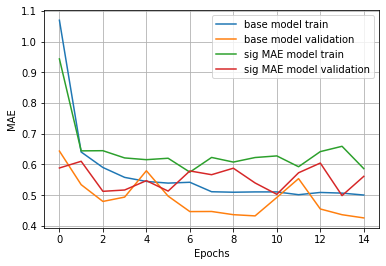

In [93]:
compare_history([history, history_sig_mae], ["base model", "sig MAE model"], [15, 15])